In [25]:
from datasets import load_dataset

# ds = load_dataset("Smith42/galaxies", split='test') # , cache_dir="PATH/TO/MY/CACHE/DIR"
metadata = load_dataset("parquet", data_files="/pscratch/sd/s/sihany/smithgalaxies/galaxies/metadata.parquet")

In [27]:
metadata

DatasetDict({
    train: Dataset({
        features: ['dr8_id', 'ra', 'dec', 'brickid', 'objid', 'hdf5_loc', 'smooth-or-featured_smooth_fraction', 'smooth-or-featured_featured-or-disk_fraction', 'smooth-or-featured_artifact_fraction', 'disk-edge-on_yes_fraction', 'disk-edge-on_no_fraction', 'has-spiral-arms_yes_fraction', 'has-spiral-arms_no_fraction', 'bar_strong_fraction', 'bar_weak_fraction', 'bar_no_fraction', 'bulge-size_dominant_fraction', 'bulge-size_large_fraction', 'bulge-size_moderate_fraction', 'bulge-size_small_fraction', 'bulge-size_none_fraction', 'how-rounded_round_fraction', 'how-rounded_in-between_fraction', 'how-rounded_cigar-shaped_fraction', 'edge-on-bulge_boxy_fraction', 'edge-on-bulge_none_fraction', 'edge-on-bulge_rounded_fraction', 'spiral-winding_tight_fraction', 'spiral-winding_medium_fraction', 'spiral-winding_loose_fraction', 'spiral-arm-count_1_fraction', 'spiral-arm-count_2_fraction', 'spiral-arm-count_3_fraction', 'spiral-arm-count_4_fraction', 'spiral-ar

In [24]:
images = load_dataset("parquet", data_files={'test': '/pscratch/sd/s/sihany/smithgalaxies/galaxies/data/test*'})

Generating test split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

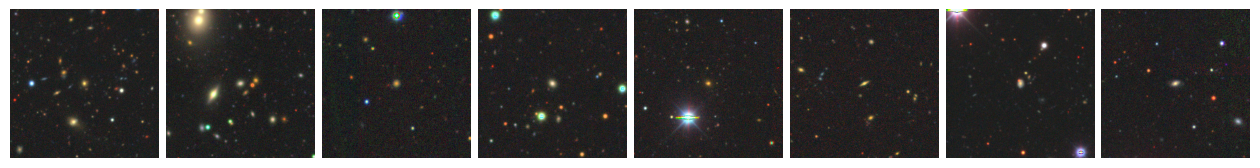

In [39]:
# plot examples
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i, image in enumerate(images['test'][:8]["image"]):
    axs[i].imshow(image)
    # axs[i].set_xlim(64, 192)
    # axs[i].set_ylim(64, 192)
    axs[i].set_axis_off()
plt.subplots_adjust(wspace=0.05, hspace=0)
fig.show()